# Big Data Architecture - Projet Final

##### Marie Mendy, Kevin Sagan, Fadi El Cheikh TAHA, Julien Ribeiro, Celia Guyobon, Roumaissa Omari

##### Lien de la consigne : https://docs.google.com/document/d/1uS88lPYsHuj94L81tZrIJ_IcdnzZTG75N-wBWZSi-b0

##### Lien des Datasets : https://ressources.data.sncf.com/explore

###Importation des librairies et modules


In [1]:
! sudo apt-get update
! sudo mkdir -p /usr/share/man/man1
! sudo apt-get install -y openjdk-11-jdk
! pip install pyspark
! pip install import-java
! pip install geopy

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [52.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,402 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports

In [3]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from pyspark import SparkContext, SQLContext
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DoubleType
from pyspark.sql.functions import col, asc,desc


In [4]:
# create SparkSession

spark = SparkSession.builder.master("local[*]") \
                    .appName('SparkTelecom') \
                    .getOrCreate()

# extract SparkContext
sc = spark.sparkContext

print('Spark CPU usage :', sc.defaultParallelism)

Spark CPU usage : 2


In [6]:
spark.read.option("delimiter", ";").option("header", True).csv("/content/tarifs-tgv-par-od-light.csv").show(10)

+--------------------+------------------+-----------------------+-----------+------------+
|                  OD|Prix d'appel 2nde |Plein Tarif Loisir 2nde|1ère classe|Commentaires|
+--------------------+------------------+-----------------------+-----------+------------+
|  NIMES-LILLE EUROPE|              30.0|                  144.0|      184.0|        null|
|MOUTIERS SALINS B...|              30.0|                  147.0|      190.0|        null|
|      LANDRY-QUIMPER|              30.0|                  147.0|      190.0|        null|
|TGV HAUTE PICARDI...|              30.0|                  150.0|      188.0|        null|
|TGV HAUTE PICARDI...|              30.0|                  150.0|      188.0|        null|
|PARIS GARE DE LYO...|              25.0|                  121.0|      166.0|        null|
|PARIS GARE DE LYO...|              25.0|                   88.0|      119.0|        null|
|LIMOGES BENEDICTI...|              25.0|                   88.0|      111.0|        null|

In [7]:
df = spark.read.option("delimiter", ";").option("header", True).csv("/content/tarifs-tgv-par-od-light.csv")
df.show(5) # Affiche les 5 premières lignes du fichier csv
df.printSchema() # Affiche le schéma root avec les différentes colonnes et leur type
df.createOrReplaceTempView("SNCF_TARIFS") # Crée ou remplace un tableau temporel en utilisant un SparkDataFrame dans la session Spark

spark.sql("SELECT OD from SNCF_TARIFS").show()

+--------------------+------------------+-----------------------+-----------+------------+
|                  OD|Prix d'appel 2nde |Plein Tarif Loisir 2nde|1ère classe|Commentaires|
+--------------------+------------------+-----------------------+-----------+------------+
|  NIMES-LILLE EUROPE|              30.0|                  144.0|      184.0|        null|
|MOUTIERS SALINS B...|              30.0|                  147.0|      190.0|        null|
|      LANDRY-QUIMPER|              30.0|                  147.0|      190.0|        null|
|TGV HAUTE PICARDI...|              30.0|                  150.0|      188.0|        null|
|TGV HAUTE PICARDI...|              30.0|                  150.0|      188.0|        null|
+--------------------+------------------+-----------------------+-----------+------------+
only showing top 5 rows

root
 |-- OD: string (nullable = true)
 |-- Prix d'appel 2nde : string (nullable = true)
 |-- Plein Tarif Loisir 2nde: string (nullable = true)
 |-- 1ère cl

In [8]:
stations = spark.sql("SELECT SPLIT(OD, '-')[0] AS Station1,\
                 SPLIT(OD, '-')[1] AS Station2,\
                 SPLIT(OD, '-')[2] AS Station3,\
                 `1ère classe` from SNCF_TARIFS")

stations.printSchema()
stations.show(15)

root
 |-- Station1: string (nullable = true)
 |-- Station2: string (nullable = true)
 |-- Station3: string (nullable = true)
 |-- 1ère classe: string (nullable = true)

+--------------------+--------------------+---------------+-----------+
|            Station1|            Station2|       Station3|1ère classe|
+--------------------+--------------------+---------------+-----------+
|               NIMES|        LILLE EUROPE|           null|      184.0|
|MOUTIERS SALINS B...|             QUIMPER|           null|      190.0|
|              LANDRY|             QUIMPER|           null|      190.0|
|  TGV HAUTE PICARDIE|                AGDE|           null|      188.0|
|  TGV HAUTE PICARDIE|                SETE|           null|      188.0|
|  PARIS GARE DE LYON|              TOULON|           null|      166.0|
|  PARIS GARE DE LYON|         MONTBELIARD|           null|      119.0|
| LIMOGES BENEDICTINS|AEROPORT CDG 2 TG...|           null|      111.0|
|         CHATEAUROUX|AEROPORT CDG 2 TG

In [9]:
#Affiche les occurences où il y a 3 stations
stations = stations.filter("Station3 is NULL")
print("There is {} columns.".format(stations.count()))

stations_new = stations.drop(stations["Station3"])
print(stations_new.show())

There is 145 columns.
+--------------------+--------------------+-----------+
|            Station1|            Station2|1ère classe|
+--------------------+--------------------+-----------+
|               NIMES|        LILLE EUROPE|      184.0|
|MOUTIERS SALINS B...|             QUIMPER|      190.0|
|              LANDRY|             QUIMPER|      190.0|
|  TGV HAUTE PICARDIE|                AGDE|      188.0|
|  TGV HAUTE PICARDIE|                SETE|      188.0|
|  PARIS GARE DE LYON|              TOULON|      166.0|
|  PARIS GARE DE LYON|         MONTBELIARD|      119.0|
| LIMOGES BENEDICTINS|AEROPORT CDG 2 TG...|      111.0|
|         CHATEAUROUX|AEROPORT CDG 2 TG...|       86.0|
|CHAMBERY CHALLES ...|           MASSY TGV|      136.0|
|           MASSY TGV|AIX LES BAINS LE ...|      136.0|
|AEROPORT CDG 2 TG...|AIX LES BAINS LE ...|      136.0|
|          NICE VILLE|    CHALON SUR SAONE|      151.0|
|MARSEILLE ST CHARLES|     LONS LE SAUNIER|      119.0|
|     BESANCON VIOTTE|    

In [10]:
stations = spark.sql("SELECT SPLIT(OD, '-')[0] AS Station1,\
                 SPLIT(OD, '-')[1] AS Station2,\
                 SPLIT(OD, '-')[2] AS Station3,\
                 `1ère classe` AS Price1 from SNCF_TARIFS")

stations.printSchema()
stations.show(15)


root
 |-- Station1: string (nullable = true)
 |-- Station2: string (nullable = true)
 |-- Station3: string (nullable = true)
 |-- Price1: string (nullable = true)

+--------------------+--------------------+---------------+------+
|            Station1|            Station2|       Station3|Price1|
+--------------------+--------------------+---------------+------+
|               NIMES|        LILLE EUROPE|           null| 184.0|
|MOUTIERS SALINS B...|             QUIMPER|           null| 190.0|
|              LANDRY|             QUIMPER|           null| 190.0|
|  TGV HAUTE PICARDIE|                AGDE|           null| 188.0|
|  TGV HAUTE PICARDIE|                SETE|           null| 188.0|
|  PARIS GARE DE LYON|              TOULON|           null| 166.0|
|  PARIS GARE DE LYON|         MONTBELIARD|           null| 119.0|
| LIMOGES BENEDICTINS|AEROPORT CDG 2 TG...|           null| 111.0|
|         CHATEAUROUX|AEROPORT CDG 2 TG...|           null|  86.0|
|CHAMBERY CHALLES ...|          

In [11]:
#TEMP VIEW de stations en df_stations 
stations.createOrReplaceTempView("df_stations")
#df-station est un temp view de stations donc on peut le convertir en Dataframe

###- Fonction itinerary Price 
lister 4 résultats d'appels de cette fonction avec des gares différentes pour chaque appel

la fonction devra retourner None dans le cas où :

 les gares passés en paramètre n'existent pas/
 le prix pour le trajet est inexistant


In [12]:
#Collect and Return None if ERROR 
def itineraryPrice(st1, st2):
    results = spark.sql(f"SELECT Price1 FROM df_stations WHERE Station1 = '{st1}' AND Station2 = '{st2}'")
    collected=results
    if collected.count()>0:
      collected=results.collect()
      return (collected[0]["Price1"])
    else:
      return None

In [13]:
#TEST 1 ERREUR : ne retourne rien donc c'est bon  
itineraryPrice("NIMESSS", "LILLE EUROPE")

In [14]:
#TEST 2 : retourne le prix du trajet entre NIMES et LILLE EUROPE
itineraryPrice("NIMES", "LILLE EUROPE")

'184.0'

###- Création d'un dataframe avec : Trajet - distance et prix 


In [20]:
df3 = all_distance.toDF(("Trajet", "Distance", "Prix"))
df3.createOrReplaceTempView("all_distance")
df3.printSchema()

root
 |-- Trajet: string (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Prix: string (nullable = true)



###- Classement descendant des distances pour chaque trajets possible

In [19]:
import time
import pickle
from pathlib import Path
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="poliakev@gmail.com")
def get_coordinates(station):
    if station not in cache:
        coords = geolocator.geocode(station)
        if coords == None :
          cache[station] = 0
        else :
          cache[station] = (coords.latitude, coords.longitude)  
    return cache[station]
def get_distance(key, location1, location2):
    if key not in cache:
        distance = geodesic(location1, location2).km
        cache[key] = distance
    return cache[key]

cache_path = 'cache.p'

cache = dict()
if Path(cache_path).exists():
    cache = pickle.load(open(cache_path, 'rb'))

print(get_coordinates("Paris"))
print(get_coordinates("Bordeaux"))
print(get_distance("NIMES - LILLE EUROPE",get_coordinates("NIMES"), get_coordinates("LILLE EUROPE") ))
pickle.dump(cache, open(cache_path, 'wb'))

# Réaliser tous les calculs entre chaque destinations :
def calculate_distance(line):
    try:
        distance = get_distance(line[0] + ' - ' + line[1],get_coordinates(line[0]), get_coordinates(line[1]))
        return (line[0] + ' - ' + line[1], distance, line[3])

    except Exception as err:
        print(get_coordinates(line[0]))
        return (line[0] + ' - ' + line[1], 0, line[3])
    
all_distance = stations.rdd.map(calculate_distance)

(48.8566969, 2.3514616)
(44.841225, -0.5800364)
762.4040500371942


In [ ]:
all_distance.take(10)

In [21]:
top10distance = spark.sql("SELECT * FROM all_distance ORDER BY Distance DESC LIMIT 10")
top10distance.show()

+--------------------+-----------------+-----+
|              Trajet|         Distance| Prix|
+--------------------+-----------------+-----+
|MACON LOCHE TGV -...|9445.444620837034| 67.0|
|SABLE - LA ROCHE ...|7251.176691127758| 53.0|
|CHERBOURG - MANTE...|5503.279758863108| 72.0|
|JUVISY TGV - MARN...|5421.805076254279| 47.0|
|CHATEAUROUX - AER...|5189.857243400858| 86.0|
|AEROPORT CDG 2 TG...|5098.862427059098|154.0|
|AEROPORT CDG 2 TG...|5094.620382737515|136.0|
|LIMOGES BENEDICTI...|5079.401607534289|111.0|
|AEROPORT CDG2 TGV...|4975.375322226876|133.0|
|   MEUSE - LUNEVILLE|3169.778002962707| 46.0|
+--------------------+-----------------+-----+



###- Visualisation

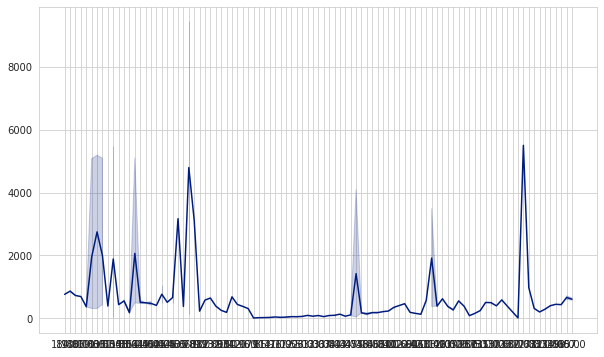

<Figure size 432x288 with 0 Axes>

In [26]:
distance = df3.select("Distance").rdd.flatMap(lambda x: x).collect()
prix = df3.select("Prix").rdd.flatMap(lambda x: x).collect()

fig = plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')

sns.lineplot(x=prix,
            y=distance)

plt.show()
plt.clf()